In [15]:
import heapq
import itertools
import os
import re
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown as md
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import measurements
from skimage.filters import threshold_otsu
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# Pre-processing
from sklearn.neighbors import KNeighborsClassifier

from Hackaton.python.read_pics import get_pics_from_file
mpl.style.use('default')

Ouverture du fichier de pics Hackaton/data/pics_LOGINMDP.bin


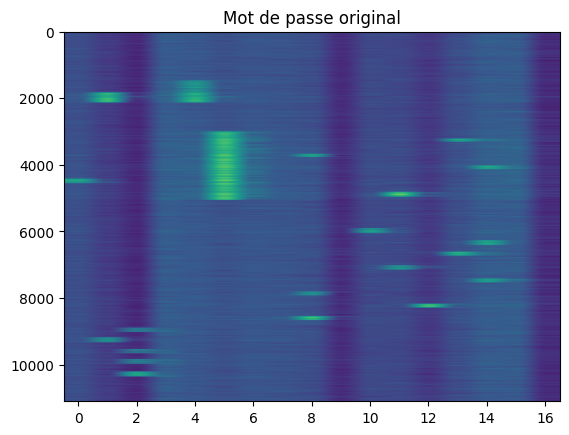

In [2]:
pics_login, info = get_pics_from_file(f'Hackaton/data/pics_LOGINMDP.bin')
plt.title("Mot de passe original")
plt.imshow(np.array(pics_login), aspect="auto")

Le but du challenge est de retrouver le maximum d'informations dans le signal ci-dessus jusqu'au
**Login et Mot de passe**.


### Creation du dataset

In [51]:
mean_dic = dict()
pics_no_key, _ = get_pics_from_file(f'Hackaton/data/pics_NOKEY.bin')
signal_no = np.array(pics_no_key)
mean_dic['pics_NOKEY.bin'] = signal_no.mean(axis=0)
noise = mean_dic['pics_NOKEY.bin']

pics_dic = {'pics_0.bin': 1, 'pics_1.bin': 2, 'pics_2.bin': 2, 'pics_3.bin': 2,
            'pics_4.bin': 2, 'pics_5.bin': 9, 'pics_6.bin': 9, 'pics_7.bin': 9,
            'pics_8.bin': 9, 'pics_9.bin': 9, 'pics_A.bin': 14, 'pics_B.bin': 10,
            'pics_C.bin': 13, 'pics_CTRL.bin': 4, 'pics_D.bin': 13, 'pics_E.bin': 13,
            'pics_ENTER.bin': 2, 'pics_F.bin': 7, 'pics_G.bin': 8, 'pics_H.bin': 10,
            'pics_I.bin': 11, 'pics_J.bin': 10, 'pics_K.bin': 11, 'pics_L.bin': 12,
            'pics_M.bin': 0, 'pics_N.bin': 8, 'pics_O.bin': 12, 'pics_P.bin': 0,
            'pics_Q.bin': 14, 'pics_R.bin': 7, 'pics_S.bin': 6, 'pics_SHIFT.bin': 5,
            'pics_SPACE.bin': 6, 'pics_SUPPR.bin': 1, 'pics_T.bin': 8, 'pics_U.bin': 10,
            'pics_V.bin': 7, 'pics_W.bin': 14, 'pics_X.bin': 6, 'pics_Y.bin': 8, 'pics_Z.bin': 6}


pics_name = os.listdir('Hackaton/data/')
pics_name.remove('pics_LOGINMDP.bin')
pics_name.remove('pics_NOKEY.bin')
data = dict()
index_dic = dict()
for i in range(17):
    data[str(i)] = []
data["name"] = []

for n, pic_name in enumerate(pics_name):
    pics_key, info = get_pics_from_file(f'Hackaton/data/{pic_name}')
    signal = np.array(pics_key) - noise
    mean_dic[pic_name] = signal.mean(axis=0)
    index_dic[pic_name] = n
    for pics in signal:
        for i, pic in enumerate(pics):
            data[str(i)].append(pic)
        data["name"].append(pic_name)

df = pd.DataFrame(data)
df.head(5)

Ouverture du fichier de pics Hackaton/data/pics_NOKEY.bin
Ouverture du fichier de pics Hackaton/data/pics_0.bin
Ouverture du fichier de pics Hackaton/data/pics_1.bin
Ouverture du fichier de pics Hackaton/data/pics_2.bin
Ouverture du fichier de pics Hackaton/data/pics_3.bin
Ouverture du fichier de pics Hackaton/data/pics_4.bin
Ouverture du fichier de pics Hackaton/data/pics_5.bin
Ouverture du fichier de pics Hackaton/data/pics_6.bin
Ouverture du fichier de pics Hackaton/data/pics_7.bin
Ouverture du fichier de pics Hackaton/data/pics_8.bin
Ouverture du fichier de pics Hackaton/data/pics_9.bin
Ouverture du fichier de pics Hackaton/data/pics_A.bin
Ouverture du fichier de pics Hackaton/data/pics_B.bin
Ouverture du fichier de pics Hackaton/data/pics_C.bin
Ouverture du fichier de pics Hackaton/data/pics_CTRL.bin
Ouverture du fichier de pics Hackaton/data/pics_D.bin
Ouverture du fichier de pics Hackaton/data/pics_E.bin
Ouverture du fichier de pics Hackaton/data/pics_ENTER.bin
Ouverture du fich

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,name
0,0.359190,0.907443,-0.052487,0.206643,0.121165,0.211891,0.002440,-0.150697,0.152251,-0.049840,-0.087592,0.020325,-0.047645,0.193258,-0.103268,-0.224868,0.240848,pics_0.bin
1,0.145567,0.708468,-0.145260,0.327493,-0.100392,0.118507,0.064696,0.247252,0.055815,-0.241490,0.085748,0.242493,-0.079994,-0.070414,0.111576,-0.046646,0.030277,pics_0.bin
2,0.157164,0.851291,-0.057370,0.298806,0.060130,-0.076195,0.090941,-0.205629,0.154082,0.066127,-0.101019,0.111878,0.012169,0.000997,0.108524,-0.096694,0.232303,pics_0.bin
3,-0.035097,0.438693,1.176151,-0.358542,0.494700,0.070289,-0.055544,0.253356,0.398833,0.343837,-0.300604,0.216859,0.212364,-0.252909,-0.081295,0.320786,0.459965,pics_0.bin
4,-0.180361,0.480807,1.078495,-0.437888,0.445262,0.230201,-0.039675,0.050109,0.183989,0.432949,-0.331732,0.216859,0.346642,0.014425,-0.150265,0.174912,0.619877,pics_0.bin


### Analyse et Traitement du signal

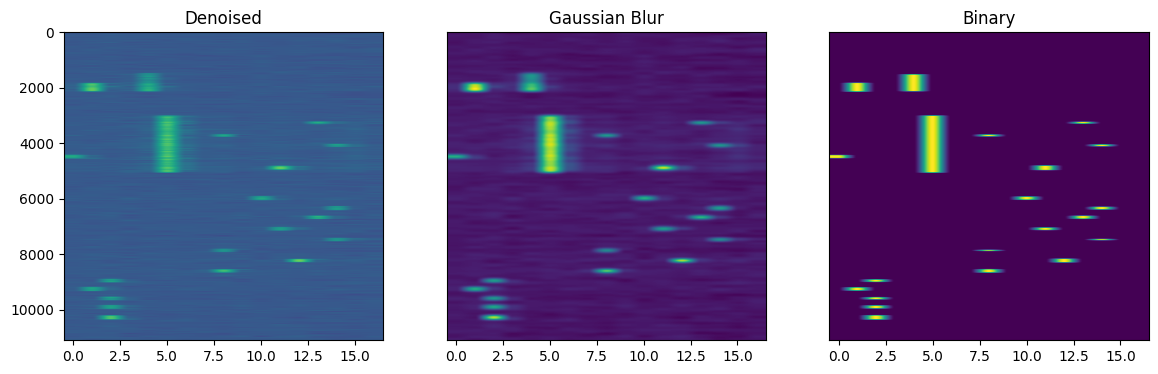

In [4]:
original_signal = (np.array(pics_login) - noise)
gf = gaussian_filter1d(original_signal, 40, 0)

binary = (gf > threshold_otsu(original_signal)).astype(int)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
i = 0
for ax, interp in zip(axs, [('Denoised', original_signal), ('Gaussian Blur', gf), ('Binary', binary)]):
    ax.imshow(interp[1],  aspect="auto")
    ax.set_title(interp[0])
    if i != 0:
        ax.get_yaxis().set_visible(False)
    i = 1

### Recherche des clusters de touches

Nombre de clusters : 27


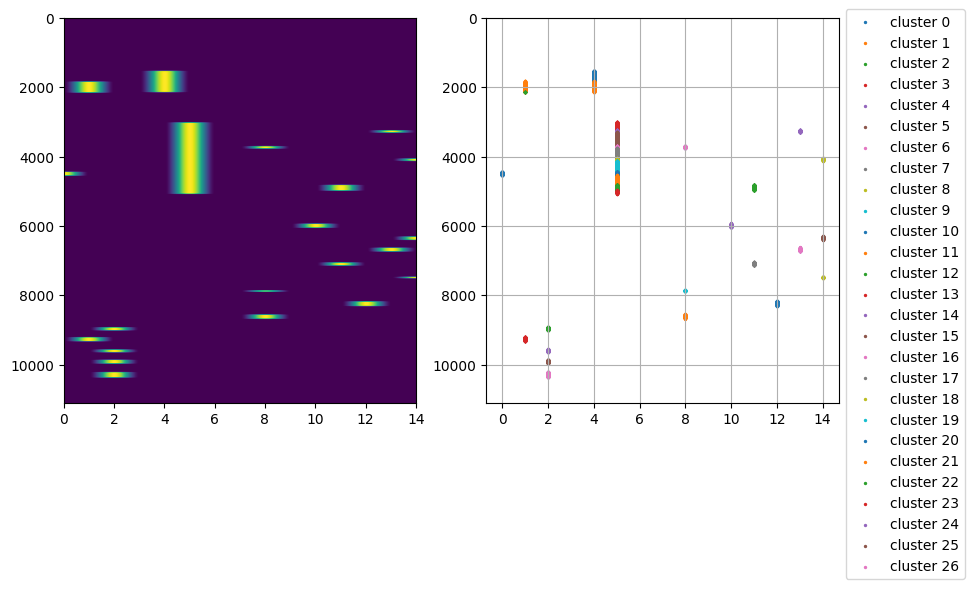

In [5]:
# regroup closed pics in groups
lw, num = measurements.label(binary, structure=[[0,1,0],
                                                [0,1,0],
                                                [0,1,0]])

# group combination of keys pressed in different groups
# even if a keys was previously pressed
prev = []
for i in range(lw.shape[0]):
    # if multiple keys pressed
    if np.count_nonzero(lw[i]) >= 1:
        cur = []
        # get pressed keys
        for j in range(lw.shape[1]):
            if lw[i][j] != 0:
                cur.append(j)
        # if not the same keys pressed
        if cur != prev:
            num += 1
            prev = cur
        # change number of group
        for j in range(lw.shape[1]):
            if lw[i][j] != 0:
                lw[i][j] = num
    # not multiple key pressed
    else:
        prev = []


clusters = []
nb = 0
for i in range(1, num + 1):
    line, col = np.where(lw == i)
    if line.shape[0] != 0:
        clusters.append((line[0], line[-1]))
        nb += 1

clusters.sort()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(binary,  aspect="auto")
axs[0].set_xlim((0, 14))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color = 0
print(f'Nombre de clusters : {nb}')
for k in range(1, np.max(lw) + 1):
    scatter = []
    for i in range(lw.shape[0]):
        for j in range(lw.shape[1]):
            if lw[i][j] == k:
                scatter.append([i, j])
    if scatter:
        temp = np.array(scatter)
        axs[1].scatter(temp[:, 1], temp[:, 0], s=2, c=colors[color % len(colors)], label="cluster " + str(color))
        color += 1
axs[1].legend(loc="upper left", bbox_to_anchor=(1, 1.04))
axs[1].grid(True)
axs[1].set_ylim((0, lw.shape[0]))
axs[1].invert_yaxis()

# Recherche du mot de passe

### Méthode utilisant un K-Nearest Neighbour classifier

In [50]:
X = df.iloc[:, :-1]
y = df.iloc[:, 17]

print("X shape = " + str(X.shape))
print("y shape = " + str(y.shape))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=True, random_state=42)

print("X train shape = " + str(X_train.shape))
print("y train shape = " + str(y_train.shape))
print("X test shape = " + str(X_test.shape))
print("y test shape = " + str(y_test.shape))

# KNN
K = 200
# Create and fit model
neigh = KNeighborsClassifier(n_neighbors=K, weights="distance", n_jobs=-1)
neigh.fit(X_train, y_train)


X shape = (338811, 17)
y shape = (338811,)
X train shape = (335422, 17)
y train shape = (335422,)
X test shape = (3389, 17)
y test shape = (3389,)


KNeighborsClassifier(n_jobs=-1, n_neighbors=200, weights='distance')

In [26]:
password = []
for cluster in clusters:
    lines = binary[cluster[0]:cluster[1], :]
    all_combinaisons = []
    for i in range(lines.shape[1]):
        if lines[0][i] and i != 15 and i != 3 and i != 16:
            all_combinaisons.append([k for k,v in pics_dic.items() if v == i])
    res = []
    to_predict = np.copy(original_signal[cluster[0]:cluster[1], :])
    if all_combinaisons:
        if len(all_combinaisons) == 1:
            mean = np.mean(to_predict, axis=0)
            password.append([neigh.predict(mean.reshape(1, -1))[0]])


        else:
            combinaisons = list(itertools.product(*all_combinaisons))
            minlist = np.zeros(len(combinaisons))
            for i, combinaison in enumerate(combinaisons):
                pertubation_sum = np.zeros(17)
                for j in combinaison:
                    pertubation_sum += mean_dic[j]
                minlist[i] = np.linalg.norm(to_predict - pertubation_sum)
            password.append(list(combinaisons[np.argmin(minlist)]))

def print_password(arr):
    arr = [([(re.search('pics_(.*).bin', key).group(1)) for key in keys]) for keys in arr]
    arr = [([str.lower(x) if x not in ['SHIFT', 'CTRL', 'SUPPR', 'ENTER'] else x for x in keys]) for keys in arr]
    arr = [sorted(keys) for keys in arr]
    for i in arr:
        tmp = ""
        for j in i:
            tmp += j + " "
        print(tmp)

print('Résultat du mot de passe: ')
print_password(password)



Résultat du mot de passe: 
CTRL 
CTRL SUPPR 
SUPPR 
SHIFT 
SHIFT d 
SHIFT 
SHIFT g 
SHIFT 
SHIFT a 
SHIFT 
SHIFT p 
SHIFT 
SHIFT i 
SHIFT 
h 
a 
e 
k 
a 
g 
l 
t 
3 
0 
3 
2 
ENTER 


#### Analyse des résultats

In [52]:
y_pred = neigh.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    pics_0.bin       0.76      0.55      0.64        91
    pics_1.bin       0.18      0.07      0.11        67
    pics_2.bin       0.32      0.33      0.32        88
    pics_3.bin       0.32      0.17      0.22        88
    pics_4.bin       0.36      0.50      0.42       108
    pics_5.bin       0.47      0.39      0.43       104
    pics_6.bin       0.51      0.51      0.51        70
    pics_7.bin       0.34      0.46      0.39        72
    pics_8.bin       0.24      0.23      0.24        70
    pics_9.bin       0.52      0.54      0.53        63
    pics_A.bin       0.46      0.66      0.54        79
    pics_B.bin       0.31      0.29      0.30        75
    pics_C.bin       0.84      0.81      0.83        70
 pics_CTRL.bin       0.98      0.99      0.99       104
    pics_D.bin       0.46      0.42      0.44        74
    pics_E.bin       0.52      0.56      0.54        77
pics_ENTER.bin       0.79      0.97      0.87  

### Méthode des distances aux moyennnes


In [27]:
password = []
proba = []
brute_force_nbr = 1
for cluster in clusters:
    lines = binary[cluster[0]:cluster[1], :]
    all_combinaisons = []
    for i in range(lines.shape[1]):
        if lines[0][i] and i != 15 and i != 3 and i != 16:
            all_combinaisons.append([k for k,v in pics_dic.items() if v == i])

    res = []
    to_predict = np.copy(original_signal[cluster[0]:cluster[1], :])
    if all_combinaisons:
        for i in all_combinaisons:
            brute_force_nbr *= len(i)

        combinaisons = list(itertools.product(*all_combinaisons))
        minlist = np.zeros(len(combinaisons))
        for i, combinaison in enumerate(combinaisons):
            pertubation_sum = np.zeros(17)
            for j in combinaison:
                pertubation_sum += mean_dic[j]
            minlist[i] = np.linalg.norm(to_predict - pertubation_sum)
        res += list(combinaisons[np.argmin(minlist)])
        tmp = 1
        ori = None
        for i, combinaison in enumerate(combinaisons):
            if i == 0:
                ori = minlist[i]
            else:
                tmp += (ori / minlist[i])
        tmp = 1 / tmp
        proba_tmp = []
        for i, combinaison in enumerate(combinaisons):
            proba_tmp.append((combinaison, tmp * (ori / minlist[i])))
        proba.append(proba_tmp)
    password.append(res)

print('Résultat du mot de passe: ')
print_password(password)


Résultat du mot de passe: 
CTRL 
CTRL SUPPR 
SUPPR 
SHIFT 
SHIFT d 
SHIFT 
SHIFT g 
SHIFT 
SHIFT a 
SHIFT 
SHIFT p 
SHIFT 
SHIFT i 
SHIFT 
b 
q 
c 
k 
a 
g 
o 
n 
3 
0 
2 
2 
ENTER 


#### Analyse des résultats


## Brute Force

In [38]:
md(f'Il y a {brute_force_nbr} possibilitées de mot de passe')

Il y a 4976640000 possibilitées de mot de passe

Le but est de ranger les mots de passe en fonction de leur probabilité.

In [39]:
def sort_dataset(dataset):
    """
    Sort the dataset to descending order to have the most probable letter in first
    :param dataset: value from the IA containing all the probalities for the given letter
    :return: Nothing
    """
    for letter in dataset:
        letter.sort(key=lambda tup: tup[1], reverse=True)


def find_max(dataset):
    list_max = []

    for level in dataset:
        list_max.append(max(level, key=itemgetter(1))[1])

    for i in range(len(list_max) - 1):
        list_max[i] = sum(list_max[i:])

    list_max.append(0)
    return list_max


def recursive(possibilities, dataset, index, n, cur_proba, cur_path, level_max):
    for (key, proba) in dataset[index]:
        tmp_proba = cur_proba + proba
        if len(possibilities) >= n and (tmp_proba + level_max[index + 1]) <= possibilities[0][0]:
            return
        cur_path.append(key)
        if index + 1 >= len(dataset):
            if len(possibilities) >= n:
                heapq.heappop(possibilities)
            heapq.heappush(possibilities, (tmp_proba, cur_path[:]))
            cur_path.pop()
            continue
        recursive(possibilities, dataset, index + 1, n, tmp_proba, cur_path, level_max)
        cur_path.pop()


def best_possibilities(dataset, n):
    if not dataset:
        return

    possibilities = []
    sort_dataset(dataset)
    level_max = find_max(dataset)
    recursive(possibilities, dataset, 0, n, 0, [], level_max)
    possibilities.sort(key=lambda tup: tup[0], reverse=True)
    return possibilities

keys_dic = {'pics_0.bin': '0', 'pics_1.bin': '1', 'pics_2.bin': '2', 'pics_3.bin': '3',
            'pics_4.bin': '4', 'pics_5.bin': '5', 'pics_6.bin': '6', 'pics_7.bin': '7',
            'pics_8.bin': '8', 'pics_9.bin': '9', 'pics_A.bin': 'a', 'pics_B.bin': 'b',
            'pics_C.bin': 'c', 'pics_CTRL.bin': 'CTRL', 'pics_D.bin': 'd', 'pics_E.bin': 'e',
            'pics_ENTER.bin': 'ENTER', 'pics_F.bin': 'f', 'pics_G.bin': 'g', 'pics_H.bin': 'h',
            'pics_I.bin': 'i', 'pics_J.bin': 'j', 'pics_K.bin': 'k', 'pics_L.bin': 'l',
            'pics_M.bin': 'm', 'pics_N.bin': 'n', 'pics_O.bin': 'o', 'pics_P.bin': 'p',
            'pics_Q.bin': 'q', 'pics_R.bin': 'r', 'pics_S.bin': 's', 'pics_SHIFT.bin': 'SHIFT',
            'pics_SPACE.bin': 'SPACE', 'pics_SUPPR.bin': 'SUPPR', 'pics_T.bin': 't', 'pics_U.bin': 'u',
            'pics_V.bin': 'v', 'pics_W.bin': 'w', 'pics_X.bin': 'x', 'pics_Y.bin': 'y', 'pics_Z.bin': 'z'}

def display_result(all_possibilities):
    for n, possibilities in enumerate(all_possibilities):
         for letter in possibilities[1]:
             for i in range(len(letter)):
                 if i + 1 >= len(letter) or len(letter) < 2:
                     print(keys_dic[letter[i]], end=' ')
                 else:
                     print(keys_dic[letter[i]], end='+')
         print('')

print('10 premiers mot de passe')
display_result(best_possibilities(proba, 10))

10 premiers mot de passe
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b q c k a g o n 3 0 2 2 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b q c k a g o n 2 0 2 2 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b w c k a g o n 3 0 2 2 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b w c k a g o n 2 0 2 2 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b q c k a g o n 3 0 2 3 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b q c k a g o n 2 0 2 3 ENTER 
CTRL SUPPR+CTRL SUPPR SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SHIFT SHIFT+i SHIFT b q c k a g o n 3 0 2 2 4 
CTRL SUPPR+CTRL 0 SHIFT SHIFT+d SHIFT SHIFT+g SHIFT SHIFT+a SHIFT p+SHIFT SH

In [47]:
t = (1.0                        # CTRL
     + 0.5020754663340842       # CTRL SUPPR
     + .5000900982349271        # SUPPR
     + 1.0                      # SHIFT
     + 0.3370305075706644       # SHIFT D
     + 1.0                      # SHIFT
     + 0.2537827135043709       # SHIFT G
     + 1.0                      # SHIFT
     + 0.3339735177043892       # SHIFT A
     + 1.0                      # SHIFT
     + 0.4989973463631565       # SHIFT M
     + 1.0                      # SHIFT
     + 0.5038164900348612       # SHIFT I
     + 1.0                      # SHIFT
     + 0.252288981849151        # H
     + 0.33315849785219553      # A
     + 0.3348091658747038       # C
     + 0.519008805032807        # K
     + 0.3345479644242671       # A
     + 0.25596500780561415      # T
     + 0.5086642401027562       # O
     + 0.2595138656454364       # N
     + 0.20840332119942795      # 2
     + 0.5020231940894264       # 0
     + 0.20989675839533942      # 2
     + 0.20549896557276356      # 1
     + 0.20376109494981495      # ENTER
     )
found = False
possibilities_nbr = 200000
for n, possibilities in enumerate(best_possibilities(proba, possibilities_nbr)):
    if possibilities[0] <= t:
        print(f'Founded ! Possibilities n°{n}')
        found = True
        break
if not found:
    print(f'Not Found in first {possibilities_nbr} possibilities')

Founded ! Possibilities n°167476
14.05730600254016


# Analyse et Conclusion



### Difficulté de différencier certaines touches





In [ ]:
minidf = df.loc[(df["name"] == "pics_1.bin") | (df["name"] == "pics_2.bin") | (df["name"] == "pics_5.bin")]
for i in range(0, 16, 2):
    ax = sns.lmplot(x=str(i), y=str(i+1),
      data=minidf,
      fit_reg=False,
      hue='name', # color by cluster
      legend=True,
      palette="Set1",
      scatter_kws={"s": 1})
    ax.set(ylim=(-0.5, 1.5))
    ax.set(xlim=(-0.5, 1.5))# specify the point size